In [ ]:
#Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**In this task, we are considering the samples which are belong to the top 10 classes. So, number of classes/labels is 10**.

In [ ]:
# Load the data
import pickle

path= "/content/drive/MyDrive/Advanced NLP models/data/"
# Train
with open(path + 'train_feats_10.pkl', 'rb') as f:
  train_feats_10 = pickle.load(f)

with open(path + 'train_labels_10.pkl', 'rb') as f:
  train_labels_10 = pickle.load(f)

# Test
with open(path + 'test_feats_10.pkl', 'rb') as f:
  test_feats_10 = pickle.load(f)

with open(path + 'test_labels_10.pkl', 'rb') as f:
  test_labels_10 = pickle.load(f)

In [ ]:
import numpy as np
import pandas as pd

import warnings 
warnings.filterwarnings('ignore')

**Train-Validation Split**

In [ ]:
from sklearn.model_selection import train_test_split
# Split the train into train (90%) & val sets(10%).
train_feats, val_feats, train_labels, val_labels = train_test_split(np.array(train_feats_10), np.array(train_labels_10),
                                                                    test_size=0.1, random_state=42)
print(f'Train shape : {train_feats.shape}')
print(f'Validation shape : {val_feats.shape}')

Train shape : (225000,)
Validation shape : (25000,)


**Install huggingface transformers & wandb**

In [ ]:
!pip install transformers
!pip install wandb

     |████████████████████████████████| 1.7 MB 2.8 MB/s 
     |████████████████████████████████| 180 kB 50.9 MB/s 
     |████████████████████████████████| 139 kB 51.8 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a637e3e8548df24d1b8b2ad0e80b7c794f39809ac93ca5acac0b62b697a8ddc4
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=9742596dea19c1eb7a0f251b8d41c74e1eb0cb8f5589fe24b48c4d6f9833d46b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


**Load the tokenizer**:

XLMRoberta uses sentence piece tokenizer for tokenizing the text. So, we need to install sentencepiece library.

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 1.1 MB/s 


In [ ]:
from transformers import XLMRobertaTokenizerFast

# Load the XLM RoBERTa tokenizer.
print('Loading XLM RoBERTa tokenizer...')
tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base',  do_lower_case=False)

Loading XLM RoBERTa tokenizer...


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

**Load the XLMRobertaForSequenceClassification model**:

In [ ]:
from transformers import XLMRobertaForSequenceClassification

# Load XLMRobertaForSequenceClassification, the pretrained XLM RoBERTa model with a single 
# linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use xlm-roberta-base pre-trained model
    num_labels = 10, # The number of output labels--10 for multi class classification.
)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

**Training Parameters**

For the purposes of fine-tuning, the BERT authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):          

Batch size: 16, 32        
Learning rate (Adam): 5e-5, 3e-5, 2e-5       
Number of epochs: 2, 3, 4            

We used above values as a reference for hyperparameter tuning.

In [ ]:
# Set training parameters
batch_size = 64
learning_rate = 1e-5
epochs = 3
# Maximum sequence/text length for padding texts
max_length = 80

**Tokenize & Encode**

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
# Create a Pytorch Dataset

class text_Dataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer=tokenizer
    self.max_length=max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,item):
    text = str(self.texts[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        text,
        max_length=max_length,
        add_special_tokens=True,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
       )
           
    return {
        'text':text,
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels, dtype=torch.long)
    }

In [ ]:
# Create pytorch datasets
train_dataset=text_Dataset(train_feats, train_labels, tokenizer, max_length)
test_dataset= text_Dataset(test_feats_10, test_labels_10, tokenizer, max_length)
valid_dataset=text_Dataset(val_feats, val_labels, tokenizer, max_length)

In [ ]:
data = next(iter(train_dataset))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
del train_feats_10, train_labels_10, test_feats_10, test_labels_10 
del train_feats, train_labels, val_feats, val_labels

We are using [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) API from Huggingface library to train & evaluate out model. It does heavy lifting work. Most of the work will be done using API. We just need to pass model, datasets, metrics to compute. It will also scales automatically to multiple GPU's. No need to setup GPU as it will does that.

In [ ]:
from transformers import Trainer, TrainingArguments

# Define Training Arguments
# It includes the training parameters like number of epochs, batch_size, output_dir etc

training_args = TrainingArguments(
    report_to = 'wandb',           # To report loss & accuracy & plot
    output_dir = './model',
    num_train_epochs = epochs, 
    per_device_train_batch_size = batch_size,    # Set batch size for multiple GPUs/devices
    per_device_eval_batch_size = 32, 
    do_train = True,
    do_eval  = True,
    learning_rate = learning_rate,
    lr_scheduler_type = 'linear',    # Set learning rate scheduler as linear
    logging_dir = './logs',           # Logs will be saved in this directory
    dataloader_num_workers = 4,      # Number of workers in data loader
    save_strategy = 'epoch',
    evaluation_strategy = 'epoch',
    load_best_model_at_end = True,   # Loads best model based on loss for evaluation
)

# Define metrics to report during evaluation
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
    }

# Define Trainer 
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    compute_metrics = compute_metrics
)

PyTorch: setting up devices


In [ ]:
# Train the model
print('Training started..')
trainer.train()

***** Running training *****
  Num examples = 225000
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10548
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Training started..


Epoch,Training Loss,Validation Loss


**Define a helper function for calculating simple accuracy.**

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Helper function for formatting elapsed times as hh:mm:ss**

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Training the model**

In [ ]:
# Set the seed value all over the place to make this reproducible.
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_DataLoader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_DataLoader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids, 
                       attention_mask=b_input_mask, 
                       labels=b_labels)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss+= loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_DataLoader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in valid_DataLoader:
        
        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           attention_mask=b_input_mask,
                           labels=b_labels)

        # Get the loss and "logits" output by the model. 
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss+= loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(valid_DataLoader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(valid_DataLoader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  3,516.    Elapsed: 0:01:03.
  Batch    80  of  3,516.    Elapsed: 0:02:07.
  Batch   120  of  3,516.    Elapsed: 0:03:11.
  Batch   160  of  3,516.    Elapsed: 0:04:15.
  Batch   200  of  3,516.    Elapsed: 0:05:19.
  Batch   240  of  3,516.    Elapsed: 0:06:22.
  Batch   280  of  3,516.    Elapsed: 0:07:26.
  Batch   320  of  3,516.    Elapsed: 0:08:30.
  Batch   360  of  3,516.    Elapsed: 0:09:34.
  Batch   400  of  3,516.    Elapsed: 0:10:37.
  Batch   440  of  3,516.    Elapsed: 0:11:41.
  Batch   480  of  3,516.    Elapsed: 0:12:45.
  Batch   520  of  3,516.    Elapsed: 0:13:49.
  Batch   560  of  3,516.    Elapsed: 0:14:52.
  Batch   600  of  3,516.    Elapsed: 0:15:55.
  Batch   640  of  3,516.    Elapsed: 0:16:59.
  Batch   680  of  3,516.    Elapsed: 0:18:03.
  Batch   720  of  3,516.    Elapsed: 0:19:07.
  Batch   760  of  3,516.    Elapsed: 0:20:11.
  Batch   800  of  3,516.    Elapsed: 0:21:15.
  Batch   840  of

**Training results**

Let's see the summary of the results:

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.76,0.54,0.80,1:33:19,0:03:33
2,0.50,0.42,0.86,1:33:39,0:03:32
3,0.41,0.38,0.88,1:33:30,0:03:35


Plot the training loss and validation loss to check for over-fitting:

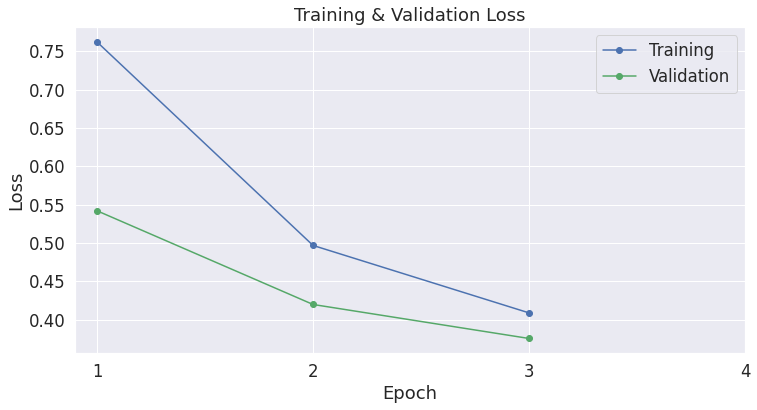

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

If we look at the loss curve, we can see that both training & validation are converging. We can improve model performance further by increasing the number of epochs.

**Model predictions on Test data**

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_DataLoader:
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('DONE.')

DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
!pip install scikit-plot

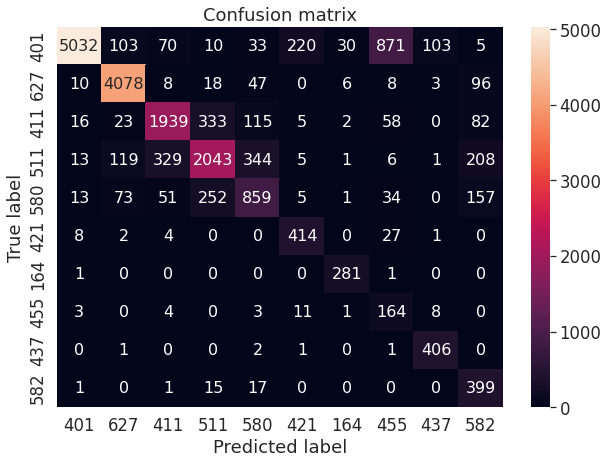

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns 
from scikitplot import metrics
# Plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
# Plot Confusion matrix
classes = [401, 627, 411, 511, 580, 421, 164, 455, 437, 582]
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes, fmt='g');
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [ ]:
classReport = classification_report(flat_true_labels, flat_predictions,target_names=[str(name) for name in classes])
print(classReport)

              precision    recall  f1-score   support

         401       0.99      0.78      0.87      6477
         627       0.93      0.95      0.94      4274
         411       0.81      0.75      0.78      2573
         511       0.76      0.67      0.71      3069
         580       0.60      0.59      0.60      1445
         421       0.63      0.91      0.74       456
         164       0.87      0.99      0.93       283
         455       0.14      0.85      0.24       194
         437       0.78      0.99      0.87       411
         582       0.42      0.92      0.58       433

    accuracy                           0.80     19615
   macro avg       0.69      0.84      0.73     19615
weighted avg       0.85      0.80      0.81     19615

